# MAP 512 : Tatouage numérique par code Tardos

In [27]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats

m = 1000 # Taille du tatouage : Fixée par la capacité d'accueil du support (doit être grrand pour que les pi suivent bien la distribution)
n = 100000 # Nombre d'utilisateurs : Evolue au fur et à mesure que des utilisateurs se rajoutent
t = 1/300
c = 10 # Taille de la collusion maximale considérée

## Code de Tardos
Cette section propose plusieurs fonctions pour mettre en application la méthode proposée par Tardos.
- *matrice_identifiants* calcule une matrice de $n$ identifiants de taille $m$ par la méthode de Tardos. Les paramètres $p_i$ de Bernouilli de chaque bit de l'identifiant sont tirés selon la loi de densité $f(p) = \frac{Cte}{\sqrt{p(1-p)}}\mathbb{1}_{[t,1-t]}(p)$. On doit donc avoir $t<\frac{1}{2}$.
- *score_tardos* calcule le score de Tardos de l'identifiant $x$ par rapport à $y$ sachant la distribution des $p_i$.

### Calcul de la fonction de répartition de la loi de densité $f$
Le chagement de variable $q=\sqrt{p}$ donne :
$$\int_t^x{f\left(p\right)dp} = \int_t^x{\frac{Cte\cdot dp}{\sqrt{p(1-p)}}} = \int_\sqrt{t}^\sqrt{x}{\frac{Cte\cdot dq}{2\sqrt{(1-q^2)}}} = 2\cdot Cte\left[Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)\right]$$
Donc $Cte = \frac{1}{2\left[Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right]}$
et la fonction de répartition de cette loi vaut $F(x)=\frac{Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)}{Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)}$ sur $[t,1-t]$.  
Puis $F^{-1}(u)=sin^2\left[Arcsin\left(\sqrt{t}\right)+u\cdot\left(Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right)\right]$.

In [28]:
def matrice_identifiants(n,m,t):
    # On doit avoir t < 0.5
    u = npr.rand(m)
    p = np.sin(np.arcsin(np.sqrt(t)) + u*(np.arcsin(np.sqrt(1-t))-np.arcsin(np.sqrt(t))))
    p = p*p
    X = np.array(npr.binomial(1,p,(n,m)))
    return p,X

def score_tardos(x,y,p):
    return np.sum((1-2*(x*(1-y)+y*(1-x)))*((np.sqrt((1-p)/p))**(2*x-1)))

In [29]:
p,X = matrice_identifiants(n, m, t)
score_tardos(npr.rand(m), X[0], p)

-310.69233239563454

-310.69233239563454

## Monte Carlo naïf pour trouver la p-valeur
Soit $y$ un identifiant trouvé dans une copie pirate et $x$ l'identifiant d'un utilisateur.  
On suppose les $p_i$ connus.  
Quelle est la probabilité $p_x$ qu'un innocent ai un score supérieur à celui de x ?  
Pour répondre à cette question nous utiliserons un estimateur Monte Carlo naïf :
$$\hat{p_x}=\frac{1}{N}\overset{N}{\underset{k = 1}\sum}{\mathbb{1}_{S\left(X_k\right)\geq S(x)}}\ \ \text{avec}\ \ X_k \overset{iid}{\sim}\left[\mathcal{Bernoulli}(p_i)\right]_{1\leq i\leq m}$$

In [30]:
def MC_naif(N,p,x,y):
    score = np.array([score_tardos(npr.binomial(1,p),y,p) for i in range(N)])
    return np.average(score >= score_tardos(x,y,p))

In [31]:
MC_naif(10000, p, X[0], npr.rand(m))

0.3202

0.3202

## Stratégie de la collusion
Nous allons proposer et comparer 3 stratégies pour la collusion :
- *vote_majoritaire* : suit le principe du vote majoritaire
- *entrelacement* : un membre de la collusion est tiré uniformément pour chaque bit
- *pile_ou_face* : à chaque bit repérable par la collusion est attribué la valeur 1 avec probabilité $\frac{1}{2}$  

Nous rappelons que ces 3 stratégies respectent la *marking assumption* qui stipule : $$\forall i\in[|1,m|]  \ \ X_{1i}=X_{2i}=\cdots=X_{ci}\Rightarrow\rho_{C}(X)_{i} = X_{1i}$$
Avec $C = [|1,c|]$ la collusion et $\rho_C$ leur strategie.

In [32]:
def vote_majoritaire(C):
    return np.round(np.average(C,axis=0))

def entrelacement(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    c = len(C)
    u = npr.randint(low=0, high=c, size=m)
    return C[u,:].diagonal()

def pile_ou_face(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = npr.randint(low=0, high=2, size=m)
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u
    

In [33]:
C = X[0:3]
vote_majoritaire(C)
entrelacement(C)
pile_ou_face(C)

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,

## Distribution empirique des scores des innocents
Le but de cette partie est de fournir une repésentation empirique de la distribution des scores des innocents face à une réponse pirate trouvée, et de la comparer à celles des membres de la collusion.  
Cette étude se fait pour les trois stratégies envisagées ci-dessus.

In [51]:
def calcul_scores(X,p,c,strategie):
    n = len(X)
    # Choix de la collusion
    C_indices = npr.choice(range(n), size=c, replace=False)
    C = X[C_indices,:]
    # Etablissement de la marque pirate
    y = strategie(C)
    # Calculs des scores des innocents
    Innocents_indices = list(set(range(n)) - set(C_indices))
    X_innocents = X[Innocents_indices,:]
    Scores_innocents = np.apply_along_axis(lambda x: score_tardos(x,y,p), axis=1, arr=X_innocents)
    # Calcul des scores des colludés
    Scores_colludes = np.apply_along_axis(lambda x: score_tardos(x,y,p), axis=1, arr=C)
    return Scores_innocents,Scores_colludes

def affichage(Scores_innocents,Scores_colludes):
    plt.hist(Scores_colludes, bins=20, density=True, color='r', label='Colludés')
    # Estimation de la densité par noyau gaussien pour les innocents
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    x_plot = np.linspace(-120,120,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.xlabel('Score de Tardos')
    plt.legend()

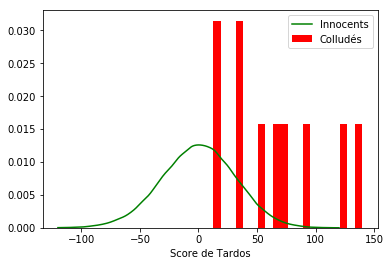

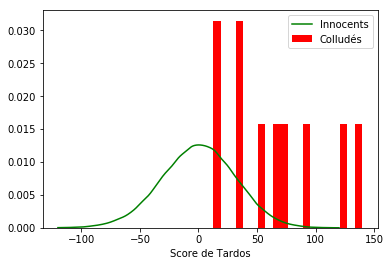

In [52]:
si,sc = calcul_scores(X,p,c,vote_majoritaire)
affichage(si,sc)

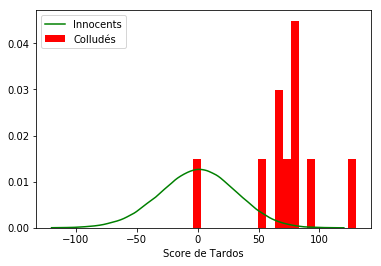

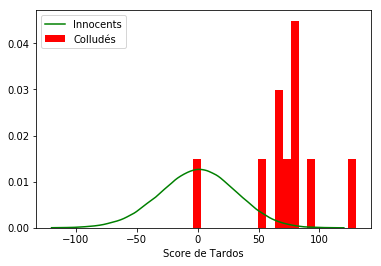

In [53]:
si,sc = calcul_scores(X,p,c,entrelacement)
affichage(si,sc)

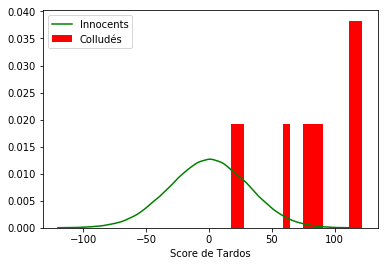

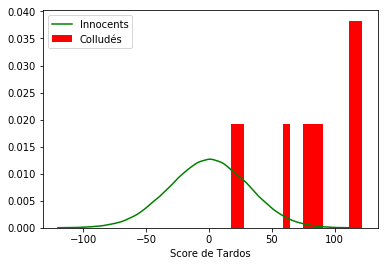

In [54]:
si,sc = calcul_scores(X,p,c,pile_ou_face)
affichage(si,sc)